# CIFAR-10 Recognizer

### Download and process data
Data will be downloaded from cs.toronto.edu website as a zip file, then unpacked. We will use only 10% of data due to lack of GPU resources. We will use the full test set though, to make a relatively fair comparison with others. The original dataset contains flatten images so in order to visualize and process them we need to reshape them to proper image size (32 x 32).

In [1]:
from data_load import maybe_download_cifar, read_data
from data_processing import get_images_and_labels
from settings import TRAIN_DATA_FILENAME, TEST_DATA_FILENAME

maybe_download_cifar()
train_data = read_data(TRAIN_DATA_FILENAME)
[train_images], [train_labels] = get_images_and_labels(train_data)
del train_data

test_data = read_data(TEST_DATA_FILENAME)
[test_images], [test_labels] = get_images_and_labels(test_data)
del test_data


Already downloaded.


Let's see the data we will be working with. CIFAR-10 contains 10 classes, so let's get 10 random images from each class and plot them.

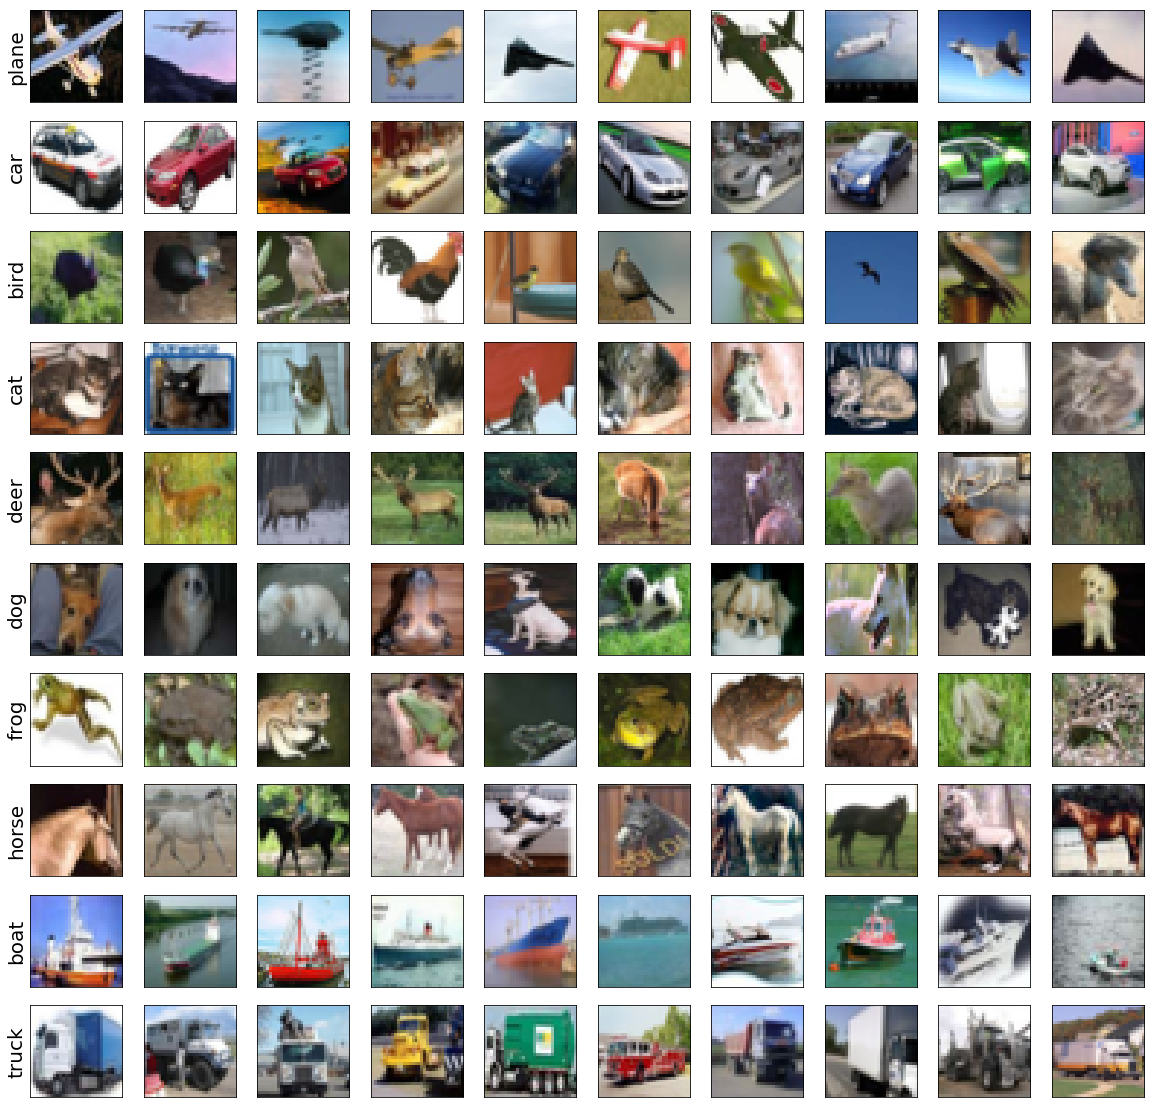

In [4]:
from data_processing import get_images_to_show
from visualisations import plot_images

chosen_images = get_images_to_show(train_images, train_labels)
classes_names = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'boat', 'truck']
plot_images(chosen_images, size=(20, 20), rows=10, columns=10, row_names=classes_names, label_size=20)

### Shallow classifier
Just to get a baseline to compare to let's see how well we can do with a simple shallow classifier. We will get HOG features from each image in the dataset and then train an SVM classifier using those features.

In [6]:
from shallow_classifier import run_search_and_evaluation_shallow
params_dict = {'orientations':[4, 9],
               'cell_size': [(4,4), (8,8)],
               'cells_per_block':[(2,2)]}

run_search_and_evaluation_shallow(train_images, train_labels, 
                                  test_images, test_labels, params_dict)

(4, (4, 4), (2, 2))->train score: 0.455val_score: 0.406
(4, (8, 8), (2, 2))->train score: 0.41125val_score: 0.377
(9, (4, 4), (2, 2))->train score: 0.35425val_score: 0.305
(9, (8, 8), (2, 2))->train score: 0.38475val_score: 0.345
best results (val_score: 0 found for (9, (8, 8), (2, 2))
final evaluation with best params. Train score: 0.4372, test score: 0.4194.


(0.4194, {'orientations': 9, 'cell_size': (8, 8), 'cells_per_block': (2, 2)})

In [2]:
from keras.applications import vgg16
model = vgg16.VGG16(weights='imagenet', input_shape=(48, 48, 3), include_top=False)

Using TensorFlow backend.


### Deeper classifier
We can use more complex features and see what happens. There are several pretrained conv-nets that we can download. The problem with most of them is that they were trained on images of different resolution, so the filters are also not ideal for our 32x32 pix images. Let's try anyway. We will resize our images to 48x48 to match the filters a bit better.
Vgg-net is a very deep network with many conv and pooling layers. So which layer would make sense for us? Definitely not the last one! The patterns learned there are way too big for our purposes. Let's try to visualise and see what would give us the biggest response for few neurons at every conv layer.

In [4]:
from visualisations import get_filters

filter_images = get_filters(model)

computing filter visualisations for layer block1_conv1
computing filter visualisations for layer block1_conv2
computing filter visualisations for layer block2_conv1
computing filter visualisations for layer block2_conv2
computing filter visualisations for layer block3_conv1
computing filter visualisations for layer block3_conv2
computing filter visualisations for layer block3_conv3
computing filter visualisations for layer block4_conv1
computing filter visualisations for layer block4_conv2
computing filter visualisations for layer block4_conv3
computing filter visualisations for layer block5_conv1
computing filter visualisations for layer block5_conv2
computing filter visualisations for layer block5_conv3


### Visualisation

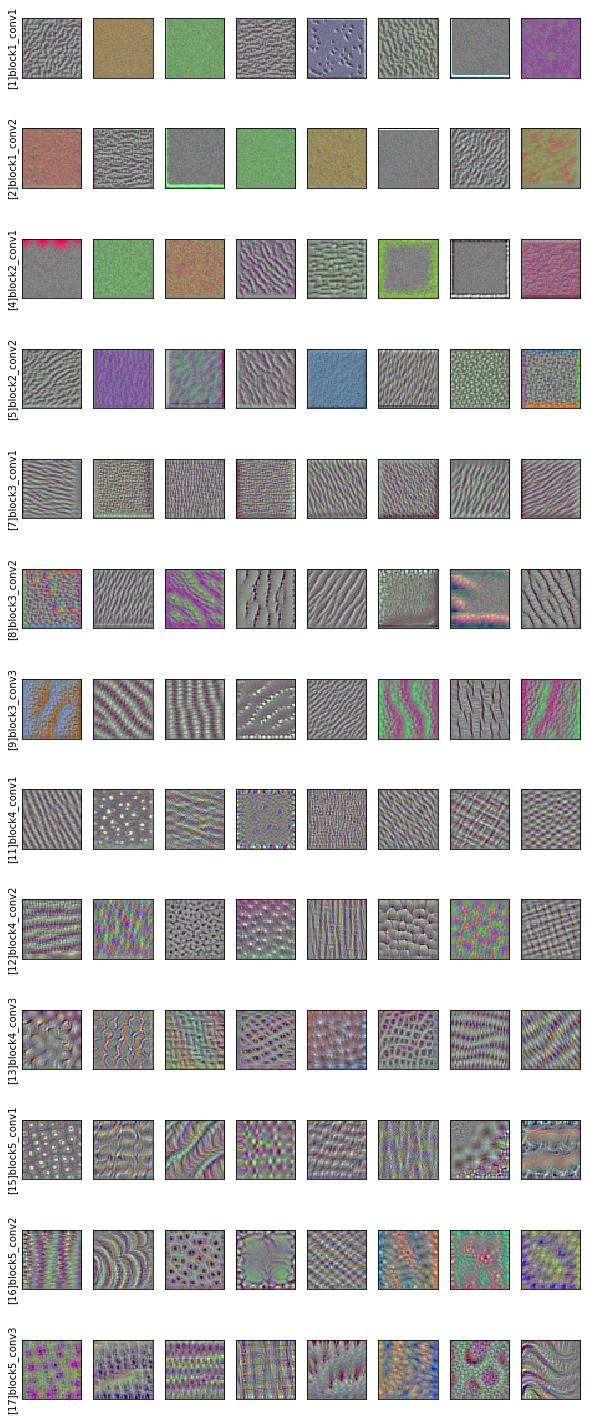

In [5]:
from visualisations import plot_images, get_conv_layer_names
conv_layer_names = get_conv_layer_names(model)
plot_images(filter_images,size=(10, 26), columns=8, rows=13, row_names=conv_layer_names)

It looks like layer four, five or seven are good candidates. For lower layers the features that are detected are a bit too small and generic, and for higher layers a bit too complex. Let's run validation for all the layers and find out if we were right.

In [5]:
from deep_classifier import run_search_and_evaluation_deep

layers = [e for e, layer in enumerate(model.layers[:-4])
            if 'conv' in layer.name]
params_to_test = {'layer_number': layers}
run_search_and_evaluation_deep(model, train_images, train_labels, test_images, test_labels, params_to_test)

Trying params combination: {'layer_number': 1}
getting features for training
training svm classifier
evaluating
The result was: 0.3375 for train and 0.28 for val
Trying params combination: {'layer_number': 2}
getting features for training
training svm classifier
evaluating
The result was: 0.464 for train and 0.378 for val
Trying params combination: {'layer_number': 4}
getting features for training
training svm classifier
evaluating
The result was: 0.985 for train and 0.496 for val
Trying params combination: {'layer_number': 5}
getting features for training
training svm classifier
evaluating
The result was: 1.0 for train and 0.194 for val
Trying params combination: {'layer_number': 7}
getting features for training
training svm classifier
evaluating
The result was: 1.0 for train and 0.082 for val
Trying params combination: {'layer_number': 8}
getting features for training
training svm classifier
evaluating
The result was: 1.0 for train and 0.082 for val
Trying params combination: {'layer

(0.53400000000000003, {'layer_number': 4})

We can visualise features extracted by our CNN by extracting two Principal Components using PCA algorithm.

preprocessing images
getting features
getting pc
building visualisation


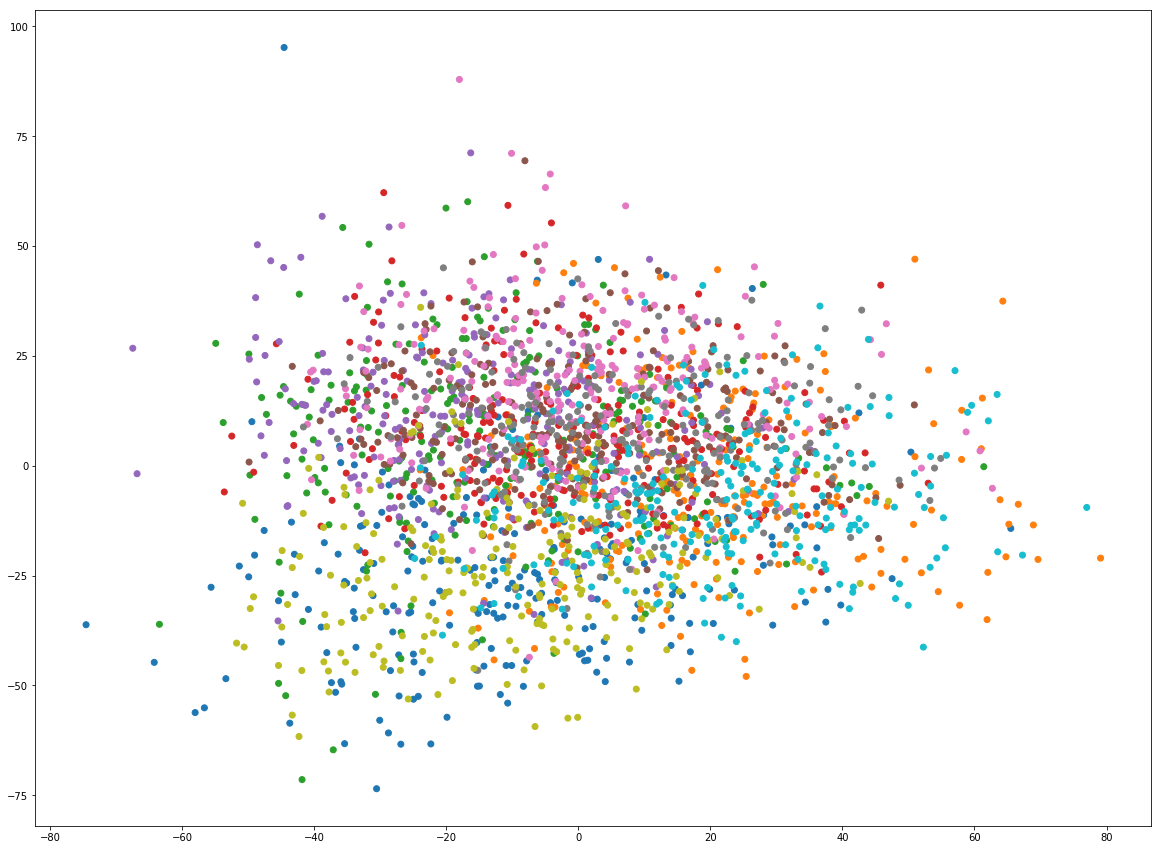

In [6]:
best_params = {'layer_number': 4}
from deep_classifier import run_pca_visualisation
run_pca_visualisation(model, train_images, best_params, train_labels)

## Conclusion
This notebook shows that features extracted by a Convolutional Neural Network, even trained on a totally different dataset help a shallow classifier perform a lot better then classical algorithms like eg. HOG. This is just a notebook to play with data and there are a lot of things that could be improved in the code - remove redundunt code, add tests, make visualisations prettier, use logging. There are many SVM hyperparameters to tune (eg. C parameter or gamma parameter) and this could make the results a lot better. Due to lack of resources only a fraction of data was used for training, so the overall result could also be improved by using the whole dataset. But all in all I think one thing is clear from this notebook: CNNs (and NNs in general) really awesome :)